# Linear Model

This notebook demonstrates the full process of training a model in pytorch, including data loading and visualization of the results, using a simple linear model with dummy data as a minimal example

In [59]:
# necessary imports
import torch
import matplotlib.pyplot as plt

# generate toy data according to simple linear model
N = 50
torch.manual_seed(3)
x = torch.linspace(0, 10, N)
y = x * 5 + torch.randn(N) * 10

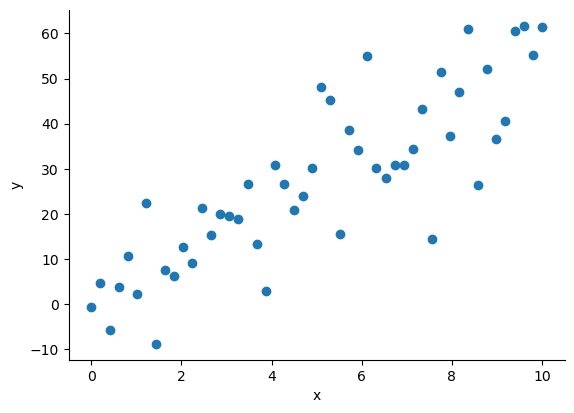

In [60]:
# # Create a scatter plot
fig, ax = plt.subplots()
ax.scatter(x, y)

ax.set_aspect(0.1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [61]:
# necessary imports
from torch.utils.data import DataLoader, Dataset

# define torch dataset
class LinearDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    # torch dataset must have __getitem__ method!
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    # torch dataset must have __len__ method!
    def __len__(self):
        return len(self.x)

# define dataloader
dataset = LinearDataset(x, y)
dataloader = DataLoader(dataset, batch_size=8)

In [62]:
# necessary imports
from torch import nn
from torch.optim import AdamW

# define model
class LinearModel(nn.Module):
    # initialize model parameters
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)

    # model must have forward method!
    def forward(self, x):
        x = self.linear(x)
        return x

# instantiate model
model = LinearModel()

# define loss function
loss_fn = nn.MSELoss()

# instantiate optimizer with model parameters
optimizer = AdamW(model.parameters(), lr=0.01)

In [63]:
# training loop
epochs = 1000
losses = []

for epoch in range(epochs):
    for x_batch, y_batch in dataloader:
        # add batch dimension
        x_batch = x_batch.unsqueeze(1)
        y_batch = y_batch.unsqueeze(1)

        # reset optimizer
        optimizer.zero_grad()

        # forward pass
        y_pred = model(x_batch)

        # calculate loss and backward pass
        loss = loss_fn(y_pred, y_batch)
        loss.backward()

        # update model parameters
        optimizer.step()
    losses.append(loss.item())

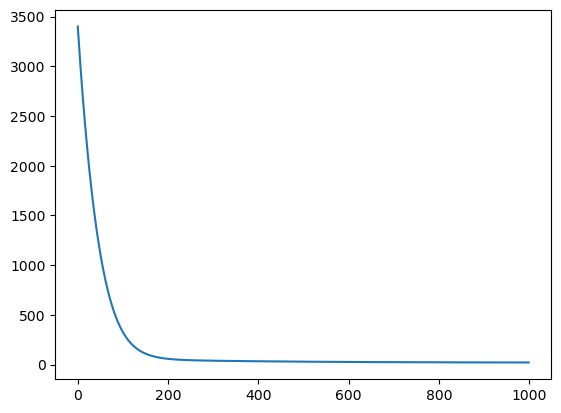

In [64]:
epoch = [i for i in range(epochs)]
plt.plot(epoch, losses)

In [65]:
model.eval() # when making predictions, set model to evaluation mode. Can be set to train mode again with model.train()
with torch.no_grad(): # disable gradient calculation
    y_pred = model(x.unsqueeze(1))

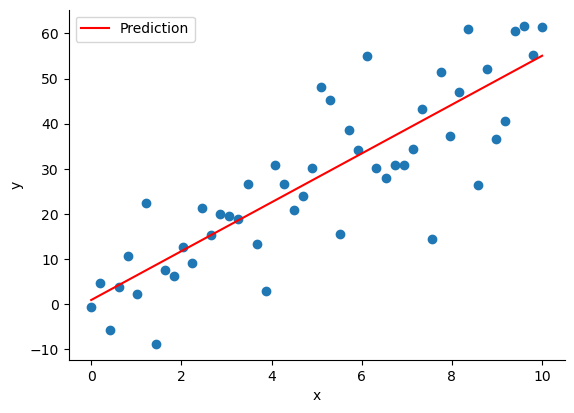

In [66]:
import matplotlib.pyplot as plt

# Create a scatter plot
fig, ax = plt.subplots()
ax.scatter(x, y)  # Optional: label for scatter points

# Set the aspect ratio as specified
ax.set_aspect(0.1)  # x:y ratio
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


# Plot the prediction line and add a label
ax.plot(x, y_pred, c='r', label='Prediction')

# Add the legend
ax.legend()

# Display the plot
plt.show()


# visualize gradual change of parameter during training

We can also visualize the prediction the model makes after every training epoch to visualize the gradual learning of the parameter. Just run the code to get the visualization gif (takes roughly 30 seconds). You do not have to understand the code.

In [67]:
# instantiate model
model = LinearModel()

# define loss function
loss_fn = nn.MSELoss()

# instantiate optimizer with model parameters
optimizer = AdamW(model.parameters(), lr=0.01)

In [68]:
# training loop
epochs = 1000
losses = []

y_preds_after_every_epoch = []
for epoch in range(epochs):
    model.train()
    for x_batch, y_batch in dataloader:
        # add batch dimension
        x_batch = x_batch.unsqueeze(1)
        y_batch = y_batch.unsqueeze(1)

        # reset optimizer
        optimizer.zero_grad()

        # forward pass
        y_pred = model(x_batch)

        # calculate loss and backward pass
        loss = loss_fn(y_pred, y_batch)
        loss.backward()

        # update model parameters
        optimizer.step()
    
    losses.append(loss.item())
    
    # make predictions after every epoch with current parameters
    model.eval()
    with torch.no_grad():
        y_pred = model(x.unsqueeze(1))
        y_preds_after_every_epoch.append(y_pred)

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import io
import os

y_min = 100000
y_max = -100000

# Adjust y_min and y_max to accommodate all y_pred values
for y_preds in y_preds_after_every_epoch:
    if y_min > y_preds.min():
        y_min = y_preds.min()
    if y_max < y_preds.max():
        y_max = y_preds.max()

images = []
for i, y_pred in enumerate(tqdm(y_preds_after_every_epoch)):
    # Create a plot for each set of y values
    fig, ax = plt.subplots()
    
    # Scatter plot
    ax.scatter(x, y)

    # Line plot of the predicted values
    ax.plot(x, y_pred, c='r', label='Prediction', linestyle='solid')

    # Set the aspect ratio and labels
    ax.set_aspect(0.1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Set same y-limits for all plots
    ax.set_ylim([y_min, y_max])

    # Add the legend
    ax.legend()

    # Plot epoch number at the top left of the plot
    ax.text(0.05, 0.95, f'Epoch: {i+1}', transform=ax.transAxes, 
            fontsize=12, verticalalignment='top', horizontalalignment='left',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    # Save the plot to a bytes buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    img = Image.open(buf)
    
    # Append the image to the list
    images.append(img)
    
    # Close the plot to free memory
    plt.close()
    
    if i == 300:  # Limit the number of frames to 300
        break

# Save the list of images as a GIF
home_dir = os.path.expanduser("~")
save_dir = os.path.join(home_dir, 'repos/DaNuMa2024/data/output_data/2_linear_model')
os.makedirs(save_dir, exist_ok=True)  # Ensure the directory exists
save_path = os.path.join(save_dir, 'parameter_development.gif')

# Create the GIF
images[0].save(save_path, save_all=True, append_images=images[1:], duration=50, loop=0)

print(f"GIF saved as '{save_path}'")
